# Domain classification task

In [117]:
import pandas as pd

In [118]:
benign = pd.read_csv('CSV_benign.csv')
malware = pd.read_csv('CSV_malware.csv')

# Labeling

In [119]:
y_benign = pd.DataFrame([0] * len(benign))
y_malware = pd.DataFrame([1] * len(malware))

# Preprocessing

# DataFrames concatanation

In [120]:
X = pd.concat([benign, malware])
y = pd.concat([y_benign, y_malware])

In [121]:
y = y.unstack() # reshaping for training

# Category columns encoding

In [122]:
cat_cols = X.select_dtypes(include=['object']).columns
cat_cols = cat_cols.union(['ASN']) # there are NaN values

In [123]:
from sklearn.preprocessing import LabelEncoder

In [124]:
enc = LabelEncoder()

for col in cat_cols:
    X[col] = X[col].astype('str')
    X[col] = enc.fit_transform(X[col])

# Features examination

In [125]:
X.hex_8.unique()

array([0])

In [126]:
X.hex_32.unique()

array([0])

- `hex_32` and `hex_8` variables always take value 0, so they brings nothing to the ML model. I delete them.

In [127]:
print('Number of rows with 0 value: ', X.dec_8.value_counts()[0])
print('Number of all df rows: ', len(X))

Number of rows with 0 value:  9515
Number of all df rows:  9516


- In the one of rows of dec_8 variable there is NaN value. But because in all others (9515) there is 0 value, I assume in NaN value there also should be 0 value. Therefore `dec_8` variable brings nothing. I delete it.

In [128]:
print('Number of rows with -1 value: ', X.Page_Rank.value_counts()[-1])
print('Number of all rows: ', len(X))

Number of rows with -1 value:  7847
Number of all rows:  9516



- `Page_Rank` takes -1 or NaN values, but by definition it should take values from 0 to 10. I delete it.

In [129]:
X = X.drop(columns=['hex_32', 'hex_8', 'dec_8', 'Page_Rank'])

# Correlation

In [130]:
c = X.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so = so[range(0, len(so), 2)] # pairs are duplicated: a-b, b-a

limit = 0.9
# so[(so > limit) & (so < 1)]
so[so > limit]

obfuscate_at_sign  oc_32                0.928980
sld                3gram                0.966398
1gram              3gram                0.966846
oc_8               puny_coded           0.969673
3gram              2gram                0.971159
2gram              sld                  0.995152
                   1gram                0.995514
1gram              sld                  0.998560
Country            Country              1.000000
ASN                ASN                  1.000000
IP                 IP                   1.000000
State              State                1.000000
Country.1          Country.1            1.000000
Domain_Name        Domain_Name          1.000000
subdomain          subdomain            1.000000
len                len                  1.000000
sld                sld                  1.000000
1gram              1gram                1.000000
entropy            entropy              1.000000
tld                tld                  1.000000
Emails             E

- Due to high correlation, I remove `1gram` and `2gram` variables.
- oc_8 and puny_coded take the same values - correlation is 1. Therefore I delete `oc_8`.

## `obfuscate_at_sign` vs `oc_32`

In [131]:
s.obfuscate_at_sign.mean()

0.14639527744786207

In [132]:
so.oc_32.mean()

0.02313056565659272

- `obfuscate_at_sign` has bigger mean correlation, that is why I delete it.

# `sld` vs `3gram`

In [133]:
s.sld.mean()

0.19271171161712358

In [134]:
s['3gram'].mean()

0.18960881483480155

- `sld` has bigger mean correlation, that is why I delete it.

In [135]:
X = X.drop(columns=['obfuscate_at_sign', '1gram', '2gram', 'oc_8', 'sld'])

# NaN handling

In [136]:
X.isna().sum()

Country                  0
ASN                      0
TTL                      0
IP                       0
Domain                   0
State                    0
Registrant_Name          0
Country.1                0
Creation_Date_Time       0
Domain_Name              0
Alexa_Rank            1662
subdomain                0
Organization             0
len                      0
longest_word             0
oc_32                    0
shortened                0
entropy                  0
Domain_Age               0
tld                      0
dec_32                   0
Emails                   0
numeric_percentage       1
puny_coded               0
typos                    0
3gram                    0
char_distribution        0
Registrar                0
Name_Server_Count     1666
dtype: int64

- `Alexa_Rank` is the popularity metric, so I replace NaN with the mean of all others values.
- With `Name_Server_Count` and `numeric_percentage` I can do the same (there are numeric values).

In [137]:
X.Alexa_Rank = X.Alexa_Rank.fillna(X.Alexa_Rank.mean())
X.Name_Server_Count = X.Name_Server_Count.fillna(X.Name_Server_Count.mean())
X.numeric_percentage = X.numeric_percentage.fillna(X.numeric_percentage.mean())

# Dataset splitting

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Models

I train a few popular models with default parameters to compare them on this task dataset.

In [139]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# Training and prediction

I choose a few popular metrics to compare models. Dataset is quite balanced.

In [140]:
import warnings
warnings.filterwarnings("ignore")

In [141]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predictions = models[key].predict(X_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)


In [142]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.668067,0.696663,0.674829
Support Vector Machines,0.679622,0.890799,0.637021
Decision Trees,0.974265,0.968655,0.981557
Random Forest,0.981618,0.973711,0.990741
Naive Bayes,0.784139,0.676441,0.880263
K-Nearest Neighbor,0.912290,0.908999,0.921107


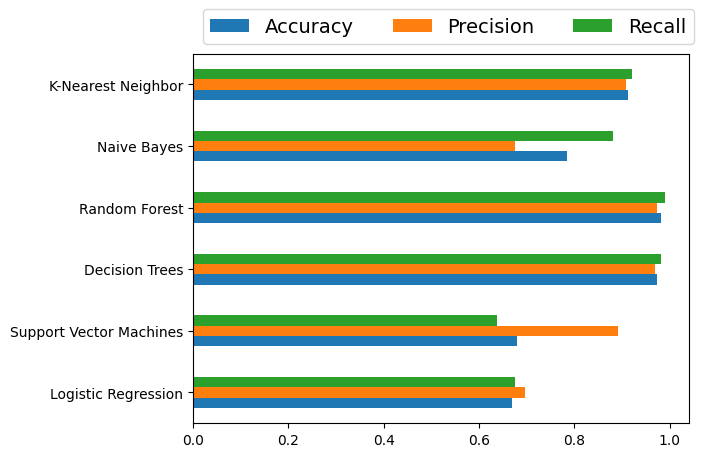

In [143]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()),
    bbox_to_anchor=(0, 1),
    loc='lower left',
    prop={'size': 14}
)

`Random Forest` and `Decision Tree` achieve the best results (with default hyperparameters). Of course hyperparameters could be optimize to achieve better results but that is the another task.

**Trees are the best!** (my Engineering Work: https://github.com/ModelOriented/forester)